In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib import patches

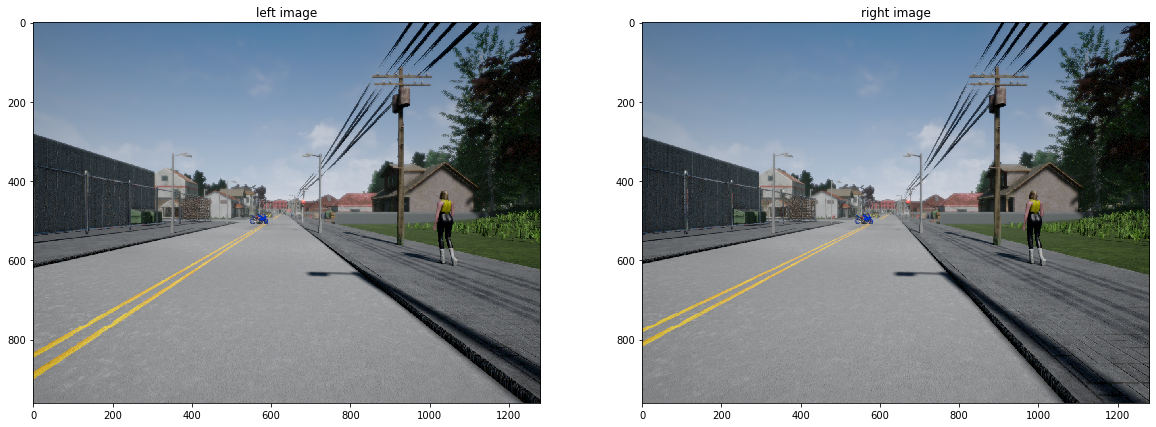

In [8]:
#Reading the two stereo images
left_image=cv2.imread("stereo_set/frame_00077_1547042741L.png")[...,::-1]
right_image=cv2.imread("stereo_set/frame_00077_1547042741R.png")[...,::-1]
#Displaying the two images
_, image_cells = plt.subplots(1, 2, figsize=(20, 20))
image_cells[0].imshow(left_image)
image_cells[0].set_title('left image')
image_cells[1].imshow(right_image)
image_cells[1].set_title('right image')
plt.show()

In [10]:
#Defining calibration matrix of both the stereo cameras
p_left = np.array([[640.0,   0.0, 640.0, 2176.0], 
                   [  0.0, 480.0, 480.0,  552.0], 
                   [  0.0,   0.0,   1.0,    1.4]])
p_right = np.array([[640.0,   0.0, 640.0, 2176.0], 
                    [   0.0, 480.0, 480.0,  792.0], 
                    [   0.0,   0.0,   1.0,    1.4]])

In [11]:
#Find disparity map
def compute_left_disparity_map(image_left, image_right):
    image_left = cv2.cvtColor(image_left, cv2.COLOR_BGR2GRAY)
    image_right = cv2.cvtColor(image_right, cv2.COLOR_BGR2GRAY)
    
    stereoProcessor = cv2.StereoSGBM_create(minDisparity=0, numDisparities=16*6, blockSize=11, P1=8*3*7**2, P2=32*3*7**2, uniquenessRatio=0)
    
    disp_left = stereoProcessor.compute(image_left, image_right).astype(np.float32)/16
    
    return disp_left

In [12]:
def decompose_projection_matrix(p):
    cameraMatrix, rotMatrix, transVect, rotMatrixX, rotMatrixY, rotMatrixZ, eulerAngles = cv2.decomposeProjectionMatrix(p)
    k = cameraMatrix
    r = rotMatrix
    t = transVect / transVect[3]
    return k, r, t

In [13]:
def calc_depth_map(disp_left, k_left, t_left, t_right):
    focal_length = k_left[0,0]
    baseline = t_left[1] - t_right[1]
    
    disp_left[disp_left==0] = 0.9
    disp_left[disp_left==-1] = 0.9
    
    depth_map = np.ones(disp_left.shape, np.single)
    depth_map[:] = (focal_length*baseline) / disp_left[:]
    return depth_map

Left Projection Matrix Decomposition:
 [[[640.0, 0.0, 640.0], [0.0, 480.0, 480.0], [0.0, 0.0, 1.0]], [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]], [[-1.9999999999999998], [0.24999999999999944], [-1.3999999999999997], [1.0]]]

Right Projection Matrix Decomposition:
 [[[640.0, 0.0, 640.0], [0.0, 480.0, 480.0], [0.0, 0.0, 1.0]], [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]], [[-1.9999999999999998], [-0.25000000000000006], [-1.4], [1.0]]]


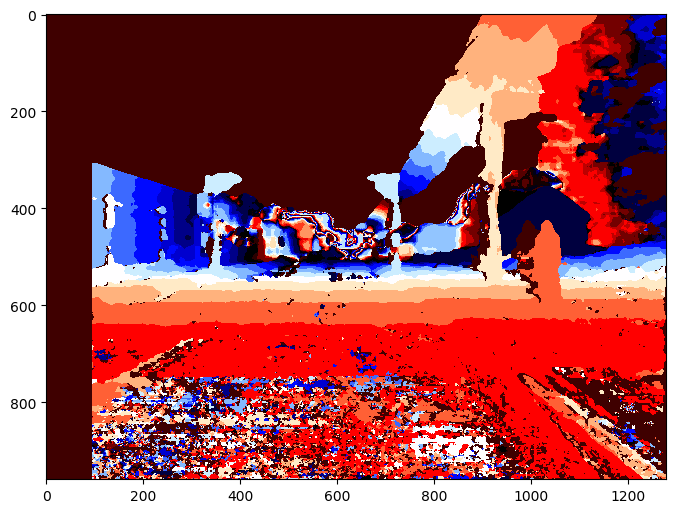

In [31]:
#Estimating depth
disp_left = compute_left_disparity_map(left_image, right_image)
k_left, r_left, t_left = decompose_projection_matrix(p_left)
k_right, r_right, t_right = decompose_projection_matrix(p_right)
depth_map_left = calc_depth_map(disp_left, k_left, t_left, t_right)
print("Left Projection Matrix Decomposition:\n {0}".format([k_left.tolist(), 
                                                            r_left.tolist(), 
                                                            t_left.tolist()]))
print("\nRight Projection Matrix Decomposition:\n {0}".format([k_right.tolist(), 
                                                               r_right.tolist(), 
                                                               t_right.tolist()]))
plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(depth_map_left, cmap='flag')
plt.show()

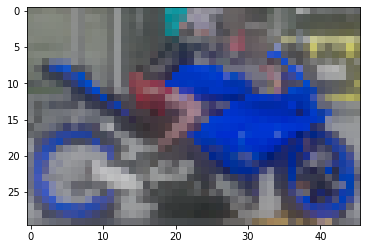

In [23]:
#Finding an object's location given the object image

#Location of the object
obstacle_image=left_image[479:509, 547:593, :]
plt.imshow(obstacle_image)
plt.show()

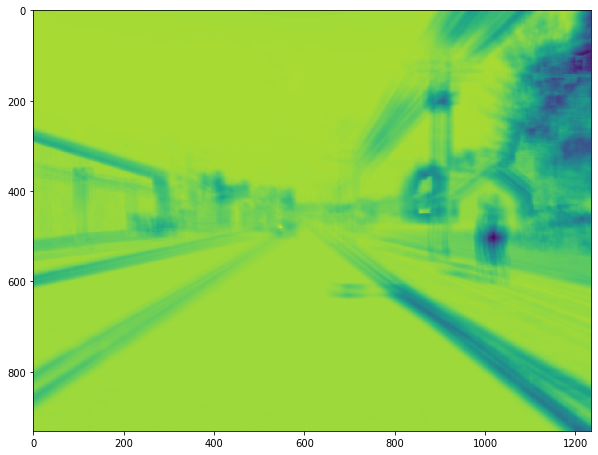

obstacle_location 
 (547, 479)


In [26]:
def locate_obstacle_in_image(image, obstacle_image):
    
    cross_corr_map = cv2.matchTemplate(image, obstacle_image, method=cv2.TM_CCORR_NORMED)
    minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(cross_corr_map)
    obstacle_location = maxLoc

    return cross_corr_map, obstacle_location

# Gather the cross correlation map and the obstacle location in the image
cross_corr_map, obstacle_location = locate_obstacle_in_image(left_image, obstacle_image)

# Display the cross correlation heatmap 
plt.figure(figsize=(10, 10))
plt.imshow(cross_corr_map)
plt.show()

# Print the obstacle location
print("obstacle_location \n", obstacle_location)

In [27]:
def calculate_nearest_point(depth_map, obstacle_location, obstacle_img):
    

    obstacle_min_x_pos = obstacle_location[1]
    obstacle_min_y_pos = obstacle_location[0]
    obstacle_width = obstacle_img.shape[0]
    obstacle_height = obstacle_img.shape[1]
    obstacle_max_x_pos = obstacle_location[1] + obstacle_width
    obstacle_max_y_pos = obstacle_location[0] + obstacle_height
    
    obstacle_depth = depth_map[obstacle_min_x_pos:obstacle_max_x_pos, obstacle_min_y_pos:obstacle_max_y_pos]
    closest_point_depth = obstacle_depth.min()

    
    # Create the obstacle bounding box 
    obstacle_bbox = patches.Rectangle((obstacle_min_y_pos, obstacle_min_x_pos), obstacle_height, obstacle_width,
                                 linewidth=1, edgecolor='r', facecolor='none')
    
    return closest_point_depth, obstacle_bbox

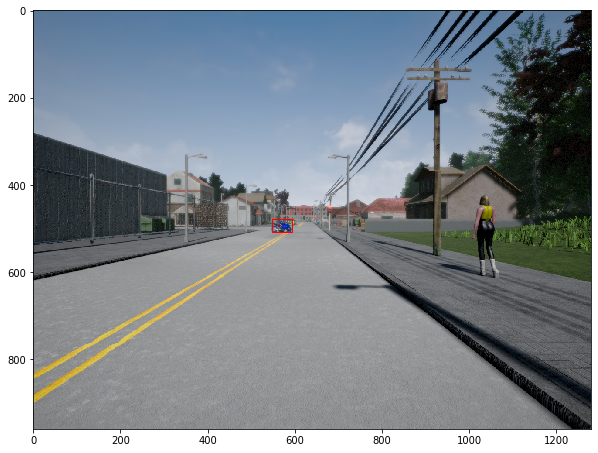

closest_point_depth 29.091


In [29]:
# Use the developed nearest point function to get the closest point depth and obstacle bounding box
closest_point_depth, obstacle_bbox = calculate_nearest_point(depth_map_left, obstacle_location, obstacle_image)

# Display the image with the bounding box displayed
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(left_image)
ax.add_patch(obstacle_bbox)
plt.show()

# Print the depth of the nearest point
print("closest_point_depth {0:0.3f}".format(closest_point_depth))